In [1]:
###############################################################
# This code is intended to 'heal' problematic a's and b's
# poduced in first round of vertical grid generation for 
# CAM7
##############################################################

# Import packages 
import sys
import argparse as arg

import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# import modules in other directories
sys.path.append('../Regridder/')
import scripGen as SG
sys.path.append('../Utils/')
import VertGridUtils as VGU

import importlib
importlib.reload( SG )
importlib.reload( VGU )

#Rdry = Con.Rdry() # 



 MyConstants in /glade/work/juliob/PyRegridding/Utils 


<module 'VertGridUtils' from '/glade/work/juliob/PyRegridding/Drivers/../Utils/VertGridUtils.py'>

 given by

p(\eta) = A(\eta) p_0 + B(\eta) p_s.

In [2]:
#####################################
myGridFiles = '/glade/work/juliob/GridFiles/'


In [3]:

Prblm_Vfile = '/glade/campaign/cgd/amp/pel/inic/L135_ne30pg3_ne30pg3_mg17.cam.i.1979-01-11-00000.nc'
Prblm_Vfile = '/glade/derecho/scratch/aherring/restart/inic/acom_ne16pg3_ne16pg3_mg17_1536_long2.cam.i.1980-01-01-00000.map_TO_L110.nc'
######################################################################
# Need L58 for consistent 'adjustment/grid alignment' if desired
######################################################################
L58file = f'{myGridFiles}/Vertical/GRID_48_taperstart10km_lowtop_BL10_v3p1_beta1p75.nc'


In [4]:
Lprblm =xr.open_dataset( Prblm_Vfile )
L58 = xr.open_dataset( L58file )

pXX  = Lprblm.hyai.values + Lprblm.hybi.values
p58  = L58.hyai.values + L58.hybi.values

hyai_prblm = Lprblm.hyai.values
hybi_prblm = Lprblm.hybi.values


In [5]:
hyaiXX , hybiXX = hyai_prblm, hybi_prblm  #VGU.Original_as_bs(pXX , gridalign=True, p58=p58 )

In [6]:
pXX.shape

(111,)

Text(0.5, 1.0, '$\\mathrm{hybrid}~~A(\\eta)~~\\mathrm{and}~~B(\\eta)$')

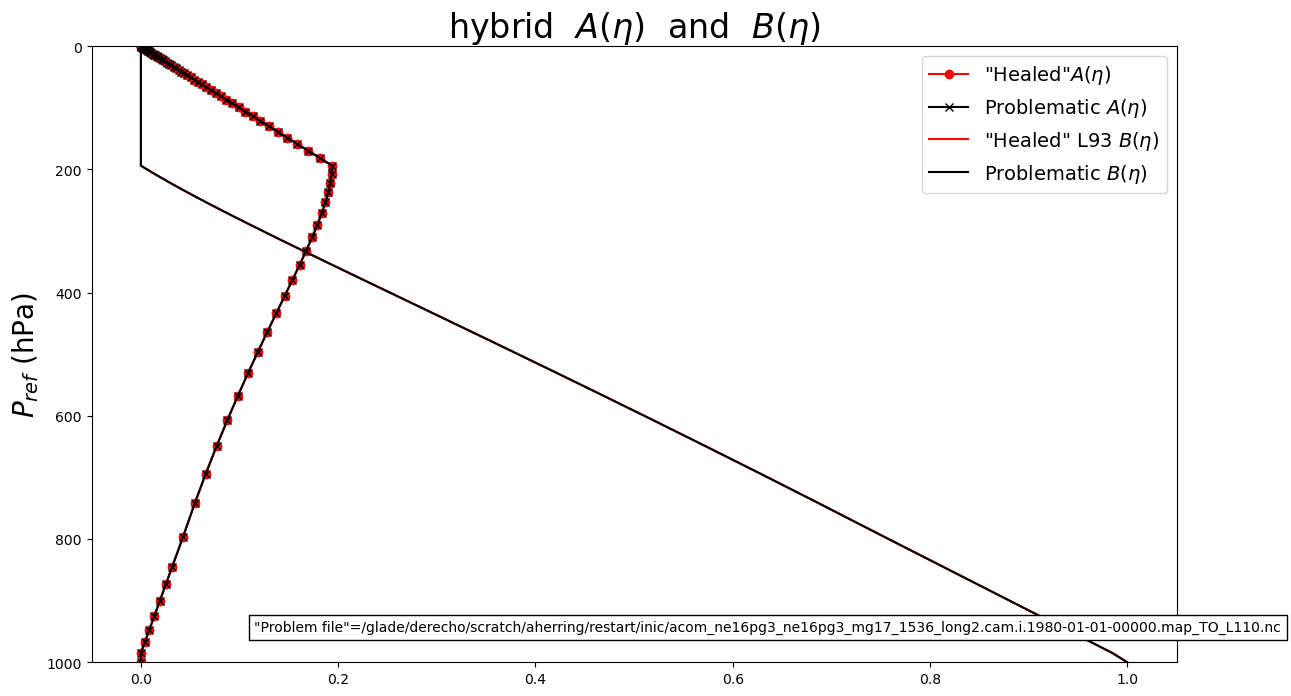

In [7]:
#plt.plot(p58,bb)
#plt.plot(p58,L58.hybi)
#plt.plot(p58,aa)

fig,ax=plt.subplots( 1,1 , squeeze=False, figsize=(14,8) )

ax[0,0].plot(hyaiXX  , 1_000.*pXX, '-o' ,color='red'  , label='"Healed"$A(\eta)$' )
ax[0,0].plot(hyai_prblm , 1_000.*pXX ,'-x', color='black' , label='Problematic $A(\eta)$'   )
ax[0,0].plot(hybiXX  , 1_000.*pXX ,color='red' , label='"Healed" L93 $B(\eta)$'  )
ax[0,0].plot(hybi_prblm , 1_000.*pXX, color='black' , label='Problematic $B(\eta)$'   )

annot3= ax[0,0].text( 0.15,.05,f'"Problem file"={Prblm_Vfile}' , transform=ax[0,0].transAxes, fontsize=10, bbox=dict(facecolor='white') )

plt.ylim( (1000.,0.) )
plt.legend(fontsize=14)
plt.ylabel( "$P_{ref}$ (hPa)" ,fontsize=20)
plt.title( "$\mathrm{hybrid}~~A(\eta)~~\mathrm{and}~~B(\eta)$", fontsize=24 )

In [8]:
nzXXe  =len(pXX)
nzXX   =nzXXe-1


hyamXX = np.zeros( nzXX )
hybmXX = np.zeros( nzXX )

for L in np.arange( 0, nzXX, 1):
    hyamXX[L] = 0.5 * ( hyaiXX[L] + hyaiXX[L+1] )
    hybmXX[L] = 0.5 * ( hybiXX[L] + hybiXX[L+1] ) 


In [9]:
import datetime
# Using the current date
current_date = datetime.datetime.now()
create_date = current_date.strftime('c%Y%m%d')

desc='OrigAB'
desc='WACCM'


ilev = (hyaiXX + hybiXX ) * 1_000. #* 100_000.
lev  = (hyamXX + hybmXX ) * 1_000. #* 100_000.


dims   = ["lev","ilev"]
coords = dict( 
    lev  = ( ["lev"],lev),
    ilev = ( ["ilev"],ilev),
)


NewVgrid = xr.Dataset( coords=coords  )

Dar = xr.DataArray( data=hyaiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyai'] = Dar

Dar = xr.DataArray( data=hybiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybi'] = Dar

Dar = xr.DataArray( data=hyamXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyam'] = Dar

Dar = xr.DataArray( data=hybmXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybm'] = Dar

newname = f'{myGridFiles}/Vertical/GRID_{str(nzXX)}L_CAM7_{desc}_{create_date}.nc'

print(newname) 

NewVgrid.to_netcdf( newname )


/glade/work/juliob/GridFiles//Vertical/GRID_110L_CAM7_WACCM_c20241016.nc


In [18]:
psfc = 1_000.
pp_A = 1_000. * hyaiXX   + psfc * hybiXX
z_A = -7_000. * np.log( pp_A/1_000. )
dz_A = -( z_A[1:]-z_A[0:-1]  )
zo_A = 0.5*( z_A[1:]+z_A[0:-1]  )


print(( z_A > 85_000. ))
print(np.sum( z_A > 85_000. ))
print(z_A[np.sum( z_A > 85_000. )-1] )

ltrunc = np.sum( z_A > 85_000. )-1


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
17
85873.38088143422


In [19]:
##################
#
# Truncate the grid if desired
#
##################
hyaiXX = hyaiXX[ltrunc:]
hybiXX = hybiXX[ltrunc:]
pXX = pXX[ltrunc:]

nzXXe  =len(pXX)
nzXX   =nzXXe-1


hyamXX = np.zeros( nzXX )
hybmXX = np.zeros( nzXX )

for L in np.arange( 0, nzXX, 1):
    hyamXX[L] = 0.5 * ( hyaiXX[L] + hyaiXX[L+1] )
    hybmXX[L] = 0.5 * ( hybiXX[L] + hybiXX[L+1] ) 


In [21]:
import datetime
# Using the current date
current_date = datetime.datetime.now()
create_date = current_date.strftime('c%Y%m%d')

desc='OrigAB_Truncated_L135'
desc='WACCM_Truncated_L110'


ilev = (hyaiXX + hybiXX ) * 1_000. #* 100_000.
lev  = (hyamXX + hybmXX ) * 1_000. #* 100_000.


dims   = ["lev","ilev"]
coords = dict( 
    lev  = ( ["lev"],lev),
    ilev = ( ["ilev"],ilev),
)


NewVgrid = xr.Dataset( coords=coords  )

Dar = xr.DataArray( data=hyaiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyai'] = Dar

Dar = xr.DataArray( data=hybiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybi'] = Dar

Dar = xr.DataArray( data=hyamXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyam'] = Dar

Dar = xr.DataArray( data=hybmXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybm'] = Dar

newname = f'{myGridFiles}/Vertical/GRID_{str(nzXX)}L_CAM7_{desc}_{create_date}.nc'

print(newname) 

NewVgrid.to_netcdf( newname )


/glade/work/juliob/GridFiles//Vertical/GRID_94L_CAM7_WACCM_Truncated_L110_c20241016.nc


In [ ]:
print( np.shape(p58))